**Load Image Data**

Image data must be loaded to pass it throught the convolutional neural network.

In [6]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
#image_path = Path("/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD/renders")

image_path = Path("/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD")
train_dir = image_path / "renders"

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(train_dir)

There are 0 directories and 50 images in '/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD/renders'.


Random image path: /Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD/renders/48_300.png
Image class: renders
Image height: 500
Image width: 500


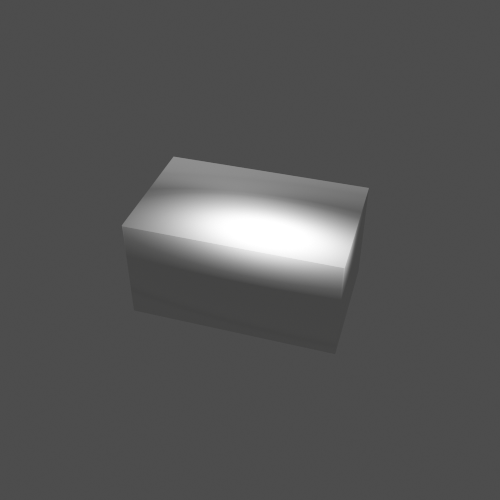

In [8]:
import random
from PIL import Image
from pathlib import Path

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(train_dir.glob("*.png"))
train_image_list, valid_image_list = image_path_list[:int(0.8*len(image_path_list))], image_path_list[int(0.8*len(image_path_list)):] 



# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

(-0.5, 499.5, 499.5, -0.5)

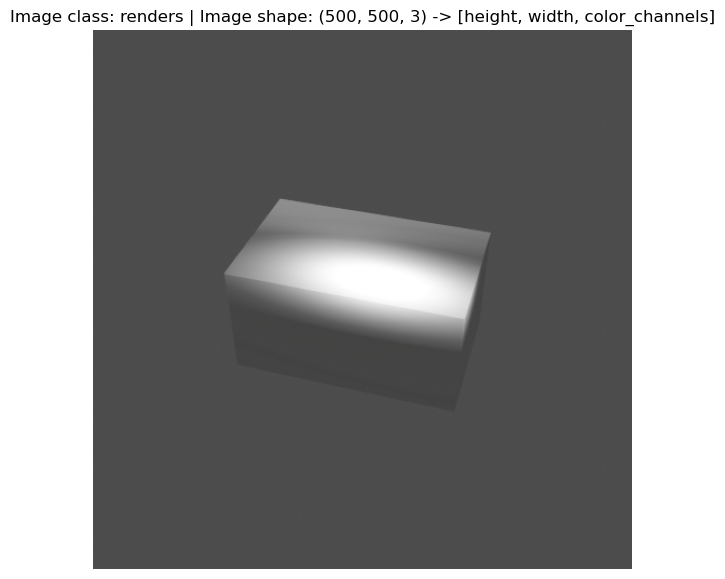

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

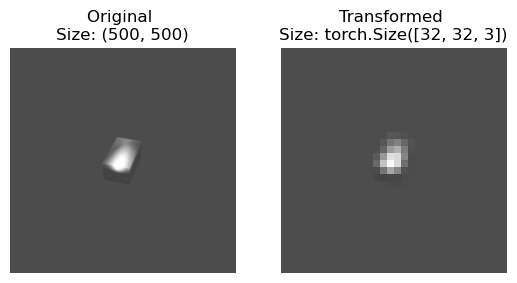

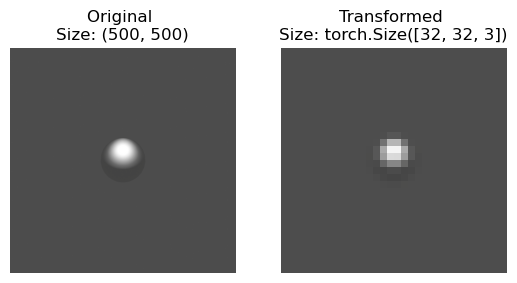

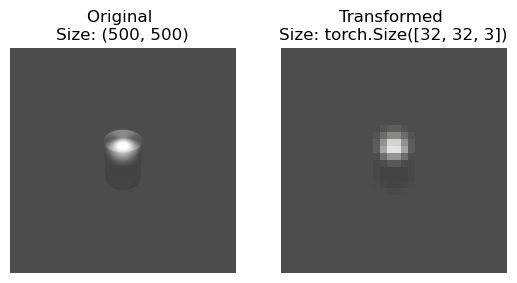

In [11]:

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])


def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            

plot_transformed_images(train_image_list, 
                        transform=data_transform, 
                        n=3)

In [29]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
image_path = Path("/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/")
train_dir = image_path / "NLP_NERF_CAD"
print(train_dir)
# Batch size will now be 32, try changing the batch_size parameter above and see what happens
BatchSize = 2

img_data = datasets.ImageFolder(root=image_path, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)


img_dataloader = DataLoader(dataset=img_data, 
                              batch_size=BatchSize, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

img = next(iter(img_dataloader))
img[0].shape



/Users/omoruyiatekha/Documents/GitHub/Referential Language for CAD/NLP_NERF_CAD


torch.Size([2, 3, 32, 32])

In [28]:
import torch 
import torch.nn as nn
from torch.nn import Embedding
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

class customCNN(nn.Module):
    def __init__(self, embedding_dim: int):

        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(16 * 5 * 5, embedding_dim*2),
            nn.ReLU(),
            nn.Linear(embedding_dim*2, embedding_dim),
            
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

model = customCNN(embedding_dim=128)
model(img[0]).shape

torch.Size([2, 128])